In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d

from sklearn.ensemble import IsolationForest  

import warnings                                                                 # Removing all those annoying Warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from mpl_toolkits import mplot3d
from pylab import rcParams                                                      
rcParams['figure.figsize'] = 30, 10

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split  
from sklearn import metrics
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix
from sklearn.decomposition import PCA

from xgboost import XGBRegressor, XGBClassifier

!pip install colorama
from colorama import Fore

In [2]:
df_contract= pd.read_csv('/content/drive/MyDrive/take_home_data/contracts.csv')
df_transaction= pd.read_csv('/content/drive/MyDrive/take_home_data/transactions.csv')

In [3]:
print(df_contract.shape, '\n\n')
df_contract.head()

(11524, 8) 




,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end
0,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaN
1,1379893624,Buckley,Turnage,1990-01-23,91360.0,2460.0,2013-09-23,NaN
2,1442099134,Mattanel,Lane,1960-04-25,94610.0,2240.0,2015-09-13,NaN
3,1404257907,Joen,Willis,1990-02-12,94109.0,3450.0,2014-07-02,2016-07-01
4,1382396400,Fabiana,Alfaro,1991-09-23,90045.0,2277.0,2013-10-22,NaN


In [4]:
df_contract.isna().sum()                                                        # we have a lot of null values in contract_end column

contract_id          0
name                 0
surname              0
dob                  0
postcode             0
rent                 0
contract_start       0
contract_end      9215
dtype: int64

In [5]:
df_contract['full_name']=df_contract['name']+df_contract['surname']+df_contract['dob']
df_contract.head()

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,full_name
0,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaN,ShaanGonzalez1951-07-26
1,1379893624,Buckley,Turnage,1990-01-23,91360.0,2460.0,2013-09-23,NaN,BuckleyTurnage1990-01-23
2,1442099134,Mattanel,Lane,1960-04-25,94610.0,2240.0,2015-09-13,NaN,MattanelLane1960-04-25
3,1404257907,Joen,Willis,1990-02-12,94109.0,3450.0,2014-07-02,2016-07-01,JoenWillis1990-02-12
4,1382396400,Fabiana,Alfaro,1991-09-23,90045.0,2277.0,2013-10-22,NaN,FabianaAlfaro1991-09-23


In [6]:
column_list=df_contract.columns
count_dataset_contracts=pd.DataFrame()
distinct_features=[]                                                                                          #Empty list to know the number of distict features,sum of all these values, and sum of values top 10 comprises
for i in column_list:                                                                                               
  count_dataset_contracts[i]= pd.Series(df_contract[i].value_counts().sort_values(ascending=False).head(10).index)      
  count_dataset_contracts[f'{i}_count']=pd.Series(df_contract[i].value_counts().sort_values(ascending=False).head(10).values).astype('int')   
  distinct_features.append((len(df_contract[i].value_counts().index),df_contract[i].value_counts().sum(),df_contract[i].value_counts().sort_values(ascending=False).head(10).sum())) 
final_tally_contract=list(zip(column_list,distinct_features))                                                          #Zipping with column_list
col_ref={}  
for i in column_list:
  if i in ['contract_end']:                                                                       #colur red shows the  Variable with missing values
    col_ref[i]='background-color: red'  
  else:
    col_ref[i]='background-color: blue'                                                                       #colur blue shows the features 
  temp=f'{i}_count'
  col_ref[temp]='background-color: green'                                                                     #colur green shows the count
def Nan_as_black(val):
  if str(val)=='nan':
    color = 'black'
    return 'color: %s' % color
count_dataset_contracts=count_dataset_contracts.style.apply(lambda x: pd.DataFrame(col_ref, index=count_dataset_contracts.index, columns=count_dataset_contracts.columns).fillna(''), axis=None).highlight_null('black').applymap(Nan_as_black)
count_dataset_contracts

,contract_id,contract_id_count,name,name_count,surname,surname_count,dob,dob_count,postcode,postcode_count,rent,rent_count,contract_start,contract_start_count,contract_end,contract_end_count,full_name,full_name_count
0,1504571043,1,Blima,8,Smith,113,1960-09-20,8,92019.000000,50,1750.000000,80,2017-04-03,15,2017-04-02,10,StrahinjaOliver1982-08-25,4
1,1432599367,1,Yehuda,8,Johnson,92,1952-05-04,7,92026.000000,50,1730.000000,73,2017-09-02,15,2017-09-01,9,SaranHusted1959-07-06,4
2,1477873284,1,Yakov,7,Williams,82,1980-01-16,7,90302.000000,48,1710.000000,73,2017-05-17,14,2016-09-09,8,EliaMasai1985-11-13,3
3,1442099134,1,Tzvi,6,Brown,58,1957-05-13,7,91361.000000,48,1550.000000,72,2017-02-16,14,2017-02-27,8,JahidHaley1985-11-28,3
4,1404257907,1,Devorah,6,Jones,56,1989-11-14,6,90813.000000,48,2020.000000,72,2014-06-02,14,2015-06-23,8,AleiyaSutter1983-11-07,3
5,1382396400,1,Mathais,6,Davis,54,1974-07-03,6,95834.000000,48,2060.000000,71,2016-10-31,14,2016-05-25,7,YaliGomez1980-03-09,3
6,1384301607,1,Le'Gion,5,Rodriguez,48,1981-12-18,6,92057.000000,48,1840.000000,71,2017-02-02,14,2017-04-03,7,FriscoJohnson1957-12-29,3
7,1329529369,1,Jigme,5,Martinez,47,1972-02-29,6,91764.000000,47,1820.000000,70,2015-07-26,14,2016-09-28,7,XingyueMathis1979-05-14,3
8,1367629776,1,Abid,5,Hernandez,45,1961-12-19,6,90403.000000,47,2000.000000,69,2017-11-10,13,2015-10-07,7,CamariClark1977-02-08,3
9,1477881500,1,Yitzchok,5,Gonzalez,42,1979-05-14,5,90275.000000,47,1980.000000,69,2017-08-17,13,2015-12-22,7,NolandKatz1968-01-04,3


In [7]:
final_tally_contract

[('contract_id', (11524, 11524, 10)),
 ('name', (9079, 11524, 61)),
 ('surname', (5583, 11524, 637)),
 ('dob', (7520, 11524, 64)),
 ('postcode', (336, 11524, 481)),
 ('rent', (482, 11524, 720)),
 ('contract_start', (2177, 11524, 140)),
 ('contract_end', (928, 2309, 78)),
 ('full_name', (10200, 11524, 32))]

final_tally_contract shows that each and every contract_id is unique in this data set, also their are 336 unique values for postcode and 482 distict rent amount 

In [8]:
tenants_with_multiple_contracts= df_contract['full_name'].value_counts().sum()-len(df_contract['full_name'].value_counts().index)
print(f'Tenants with multiple contracts are :{tenants_with_multiple_contracts}')

''' avg contracts for people with multiple IDs'''
print(f"Avg contracts for people with multiple Accounts : {df_contract['full_name'].value_counts().head(tenants_with_multiple_contracts).mean()}")

Tenants with multiple contracts are :1324
Avg contracts for people with multiple Accounts : 2.0


In [9]:
# '''
# Lets determine ideal bin size for payments it will come handy later 
# '''
# bin_sizes=[5,8,10]
# for i in bin_sizes:
#   print(f"For Number of Bins {i} contract covered are {df_contract['rent'].value_counts(bins=i)}")

In [10]:
df_contract['contract_end']= pd.to_datetime(df_contract['contract_end'])        # Converting Date coloumns into Date Time format
df_contract['contract_start']= pd.to_datetime(df_contract['contract_start']) 

In [11]:
df_contract['Duration']= (df_contract['contract_end'].sub(df_contract['contract_start'], axis=0))

In [12]:
df_contract.head()

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,full_name,Duration
0,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,ShaanGonzalez1951-07-26,NaT
1,1379893624,Buckley,Turnage,1990-01-23,91360.0,2460.0,2013-09-23,NaT,BuckleyTurnage1990-01-23,NaT
2,1442099134,Mattanel,Lane,1960-04-25,94610.0,2240.0,2015-09-13,NaT,MattanelLane1960-04-25,NaT
3,1404257907,Joen,Willis,1990-02-12,94109.0,3450.0,2014-07-02,2016-07-01,JoenWillis1990-02-12,730 days
4,1382396400,Fabiana,Alfaro,1991-09-23,90045.0,2277.0,2013-10-22,NaT,FabianaAlfaro1991-09-23,NaT


In [13]:
df_contract.Duration.describe()                                                 # we will create ML model to predict durations of contract

count                           2309
mean     824 days 14:08:09.562581200
std      493 days 19:32:24.369540184
min                 88 days 00:00:00
25%                395 days 00:00:00
50%                761 days 00:00:00
75%               1185 days 00:00:00
max               2129 days 00:00:00
Name: Duration, dtype: object

In [14]:
def days_to_int(x):
  if x is None:
    return None
  else:
    return x.days

df_contract['Duration']=df_contract['Duration'].apply(lambda x :days_to_int(x))

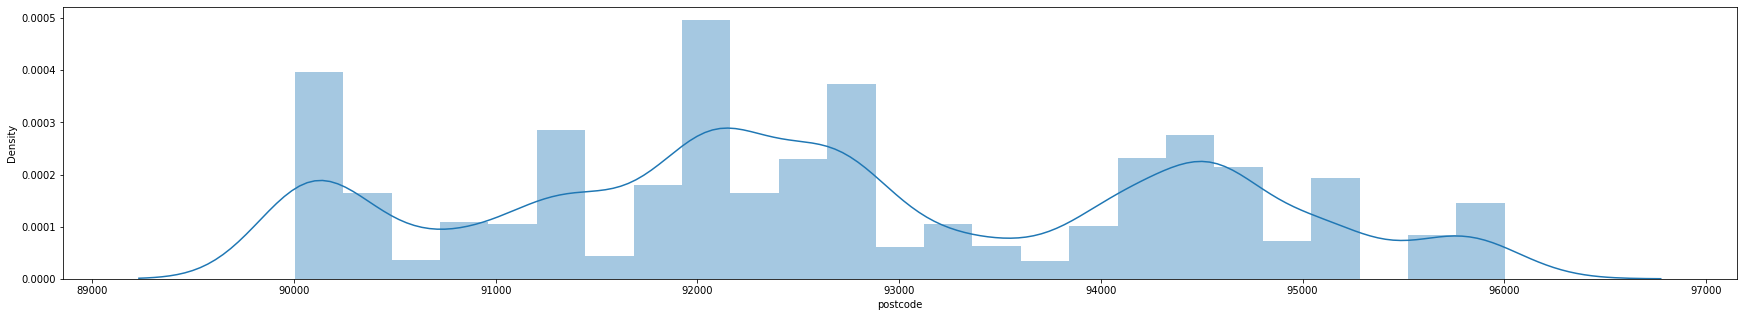

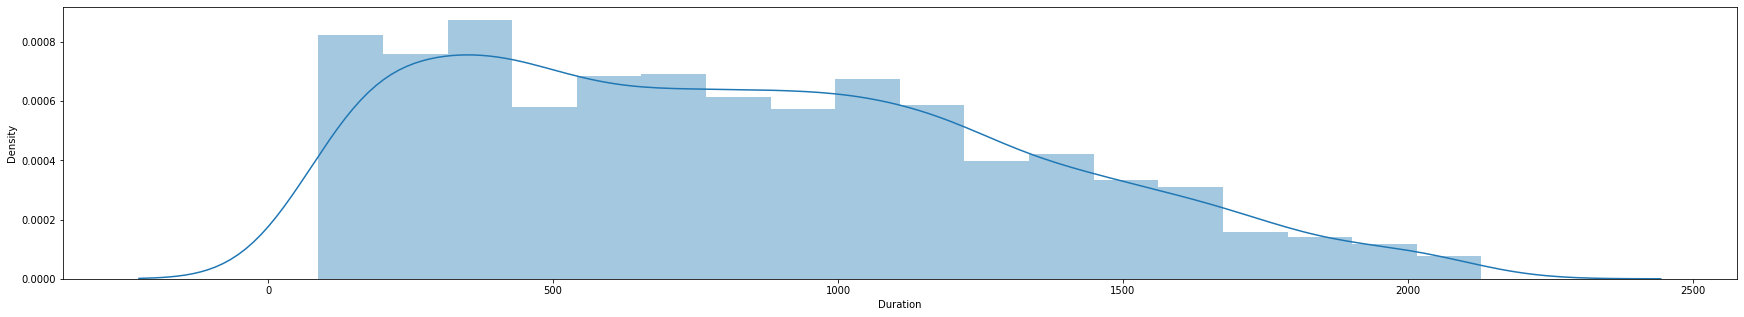

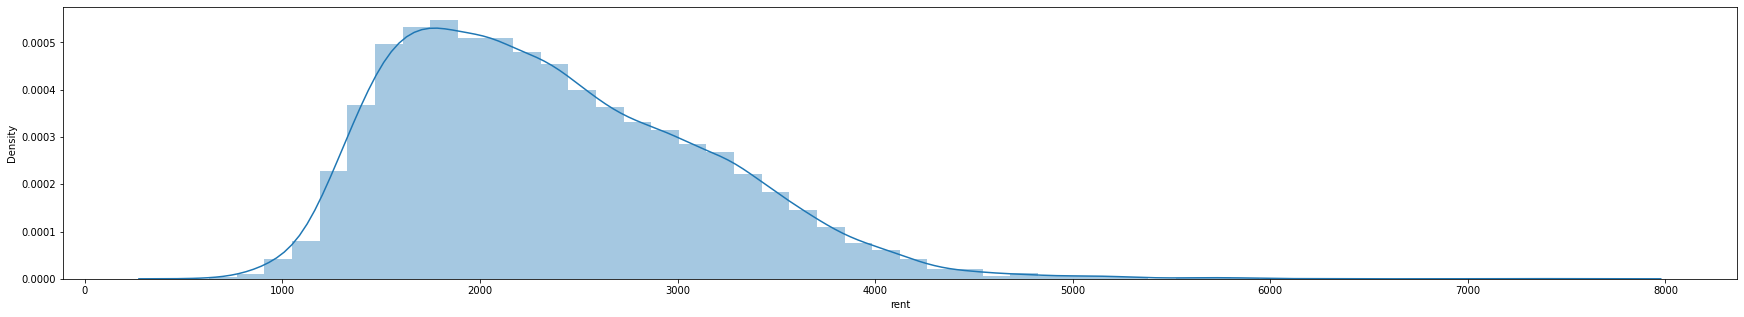

In [15]:
plot_list=['postcode', 'Duration', 'rent']
for column in plot_list:
  plt.figure(figsize=(30,5))
  sns.distplot(df_contract[column])
  plt.show()

For Transaction DataFrame

In [16]:
print(df_transaction.shape, '\n\n')
df_transaction.head()

(273679, 4) 




,contract_id,Payment_date,Amount,payment_method
0,1405033200,2014-12-11,3270.0,BANK_TRANSFER
1,1405033200,2015-01-11,3270.0,BANK_TRANSFER
2,1405033200,2015-02-11,3270.0,BANK_TRANSFER
3,1405033200,2015-03-11,3270.0,BANK_TRANSFER
4,1405033200,2015-04-11,3270.0,BANK_TRANSFER


In [43]:
df_transaction.describe()

,contract_id,Amount,payment_method_BANK_TRANSFER,payment_method_CASH,payment_method_DIRECT_DEBIT
count,2.736790e+05,273167.000000,273679.000000,273679.000000,273679.000000
mean,1.406217e+09,2431.049587,0.146299,0.048480,0.805221
std,4.799338e+07,1387.368152,0.353406,0.214779,0.396031
min,1.325379e+09,-17070.000000,0.000000,0.000000,0.000000
25%,1.364697e+09,1790.000000,0.000000,0.000000,1.000000
50%,1.405558e+09,2300.000000,0.000000,0.000000,1.000000
75%,1.443747e+09,2960.000000,0.000000,0.000000,1.000000
max,1.514685e+09,22860.000000,1.000000,1.000000,1.000000


In [17]:
df_transaction.isna().sum()                                                     # payment date and Amount have few nulls

contract_id         0
Payment_date      194
Amount            512
payment_method      0
dtype: int64

In [18]:
df=df_transaction
column_list=df.columns
count_dataset=pd.DataFrame()
distinct_features=[]                                                                                          #Empty list to know the number of distict features,sum of all these values, and sum of values top 10 comprises
for i in column_list:                                                                                               
  count_dataset[i]= pd.Series(df[i].value_counts().sort_values(ascending=False).head(10).index)      
  count_dataset[f'{i}_count']=pd.Series(df[i].value_counts().sort_values(ascending=False).head(10).values).astype('int')   
  distinct_features.append((len(df[i].value_counts().index),df[i].value_counts().sum(),df[i].value_counts().sort_values(ascending=False).head(10).sum())) 
final_tally=list(zip(column_list,distinct_features))                                                          #Zipping with column_list
col_ref={}  
for i in column_list:
  if i in ['Payment_date','Amount']:                                                                       #colur red shows the  Variable with missing values
    col_ref[i]='background-color: red'  
  else:
    col_ref[i]='background-color: blue'                                                                       #colur blue shows the features 
  temp=f'{i}_count'
  col_ref[temp]='background-color: green'                                                                     #colur green shows the count
def Nan_as_black(val):
  if str(val)=='nan':
    color = 'black'
    return 'color: %s' % color
count_dataset=count_dataset.style.apply(lambda x: pd.DataFrame(col_ref, index=count_dataset.index, columns=count_dataset.columns).fillna(''), axis=None).highlight_null('black').applymap(Nan_as_black)
count_dataset

,contract_id,contract_id_count,Payment_date,Payment_date_count,Amount,Amount_count,payment_method,payment_method_count
0,1419476543,38,2017-02-28,760,1750.000000,1598,DIRECT_DEBIT,220372.000000
1,1418696614,38,2015-02-28,515,2300.000000,1566,BANK_TRANSFER,40039.000000
2,1419386281,38,2016-02-29,481,1550.000000,1564,CASH,13268.000000
3,1417565001,38,2017-11-30,425,2100.000000,1534,nan,nan
4,1419468265,38,2017-09-30,405,2280.000000,1442,nan,nan
5,1417748068,38,2017-06-30,385,1980.000000,1437,nan,nan
6,1417918252,38,2017-04-30,374,2090.000000,1436,nan,nan
7,1417834470,38,2016-09-30,372,1950.000000,1426,nan,nan
8,1419558377,38,2016-11-30,362,1800.000000,1418,nan,nan
9,1418351249,38,2017-11-20,351,1710.000000,1397,nan,nan


In [19]:
final_tally

[('contract_id', (11524, 273679, 380)),
 ('Payment_date', (1126, 273485, 4430)),
 ('Amount', (2145, 273167, 14818)),
 ('payment_method', (3, 273679, 273679))]

Out of 273679 contract_ids we have only 11524 unique contracts which sync well with out contract_df, apart from this we have 2145 unique amounts thus we will create a bin of ideal size, for column payment_date we will drop if as the information about the frequency of payment can be retained from counts of contract_id and for payment methods I will create one hot encodings

In [20]:
'''
we can see that payment is being made every month thus count of this payment give us idea of duration until the contract was adherd
'''
df_transaction[df_transaction['contract_id']==1405033200].head()  

,contract_id,Payment_date,Amount,payment_method
0,1405033200,2014-12-11,3270.0,BANK_TRANSFER
1,1405033200,2015-01-11,3270.0,BANK_TRANSFER
2,1405033200,2015-02-11,3270.0,BANK_TRANSFER
3,1405033200,2015-03-11,3270.0,BANK_TRANSFER
4,1405033200,2015-04-11,3270.0,BANK_TRANSFER


In [21]:
one_hot_entity=['payment_method']    
column_one_hot=['payment_method']                                               # one hot encoding of Order Status so as to get the gist of number of successful, canceled orders
count=0
for i in column_one_hot:
  temp_df=pd.get_dummies(df_transaction[i], prefix=one_hot_entity[count])
  count+=1
  df_transaction=pd.concat([df_transaction, temp_df], axis=1)

In [22]:
df_transaction['Payment_date']=pd.to_datetime(df_transaction['Payment_date'])   

In [23]:
df_transaction.head(6)

,contract_id,Payment_date,Amount,payment_method,payment_method_BANK_TRANSFER,payment_method_CASH,payment_method_DIRECT_DEBIT
0,1405033200,2014-12-11,3270.0,BANK_TRANSFER,1,0,0
1,1405033200,2015-01-11,3270.0,BANK_TRANSFER,1,0,0
2,1405033200,2015-02-11,3270.0,BANK_TRANSFER,1,0,0
3,1405033200,2015-03-11,3270.0,BANK_TRANSFER,1,0,0
4,1405033200,2015-04-11,3270.0,BANK_TRANSFER,1,0,0
5,1405033200,2015-05-11,3270.0,BANK_TRANSFER,1,0,0


In [24]:
df1=df_transaction.groupby('contract_id')['Payment_date'].count()                                   # Our Features are now ready and thus i will be making the Final Dataset
df2=df_transaction.groupby('contract_id')['Amount'].mean()
df3=df_transaction.groupby('contract_id')['payment_method_BANK_TRANSFER'].sum()
df4=df_transaction.groupby('contract_id')['payment_method_CASH'].sum()
df5=df_transaction.groupby('contract_id')['payment_method_DIRECT_DEBIT'].sum()
df5=df_transaction.groupby('contract_id')['payment_method_DIRECT_DEBIT'].sum()
df6=df_transaction.groupby('contract_id')['Payment_date'].min()

columns=['frequency_of_payment','Amount','payment_method_BANK_TRANSFER','payment_method_CASH','payment_method_DIRECT_DEBIT','Payment_date']
data_frames=[df1,df2,df3,df4,df5,df6]
final_transaction_df=pd.DataFrame()
count=0
for i in columns:
  final_transaction_df[i]=data_frames[count]
  count+=1

In [25]:
df7=df_transaction.groupby('contract_id')['Payment_date'].min()
df7.head()

contract_id
1325379492   2015-01-01
1325382769   2015-01-01
1325385232   2015-01-01
1325386456   2015-01-01
1325466063   2014-12-02
Name: Payment_date, dtype: datetime64[ns]

In [26]:
# df_transaction[df_transaction['contract_id']==1325382769].head(1)['Amount']
first_month_payment={}
for i in df7.index:
  temp=df_transaction[df_transaction['contract_id']==i].head(1)['Amount']
  first_month_payment[i]=temp

In [74]:
eviction=[]
defaulter=0
for i in df_transaction.contract_id.value_counts().index:
  counter=0
  count=6
  for j in range(int((df_transaction[df_transaction['contract_id']==i].shape[0])/6)):
  # temp=np.array(df_transaction[df_transaction['contract_id']==i].iloc[counter:count].isna().sum()).sum()
    temp=list(df_transaction[df_transaction['contract_id']==i]['Amount'].iloc[counter:count])
    default=0
    for n in temp:
      if n<=0:
        defaulter+=1
        eviction.append(i)
    count+=6
    counter+=6

In [77]:
print(f'Total number of Defaulters are {defaulter}')

Total number of Defaulters are 412


In [845]:
print(final_transaction_df.shape, '\n\n')                                       # This Data set is ready and have equal number of rows as contract_df thus we will merge them
final_transaction_df.head() 

(11524, 6) 




,frequency_of_payment,Amount,payment_method_BANK_TRANSFER,payment_method_CASH,payment_method_DIRECT_DEBIT,Payment_date
contract_id,,,,,,
1325379492,30,3198.000000,30,0,0,2015-01-01
1325382769,36,1680.000000,0,36,0,2015-01-01
1325385232,30,1597.733333,0,0,30,2015-01-01
1325386456,36,2527.000000,0,0,36,2015-01-01
1325466063,37,1608.648649,0,0,37,2014-12-02


In [846]:
df_contract.set_index('contract_id', inplace=True)
df_contract.drop(['name','surname','dob','contract_end'], axis=1 , inplace=True)

In [847]:
df_contract.shape, final_transaction_df.shape

((11524, 5), (11524, 6))

In [848]:
final_df=pd.merge(df_contract, final_transaction_df, left_index=True, right_index=True)

In [849]:
final_df.head()                                                                 

,postcode,rent,contract_start,full_name,Duration,frequency_of_payment,Amount,payment_method_BANK_TRANSFER,payment_method_CASH,payment_method_DIRECT_DEBIT,Payment_date
contract_id,,,,,,,,,,,
1504571043,94123.0,3050.0,2017-09-05,ShaanGonzalez1951-07-26,NaN,5,4270.000000,0,0,5,2017-09-05
1379893624,91360.0,2460.0,2013-09-23,BuckleyTurnage1990-01-23,NaN,37,2469.972973,0,37,0,2014-12-23
1442099134,94610.0,2240.0,2015-09-13,MattanelLane1960-04-25,NaN,29,2394.482759,0,0,29,2015-09-13
1404257907,94109.0,3450.0,2014-07-02,JoenWillis1990-02-12,730.0,20,2898.000000,0,1,19,2014-12-02
1384301607,92203.0,1710.0,2013-11-13,BalkisRichardson1989-07-04,NaN,37,1714.621622,0,0,37,2014-12-13


In [947]:
rent_decided=final_df['rent']
keys_rent=rent_decided.index
values_rent=rent_decided.values

Text(0, 0.5, 'contract_id')

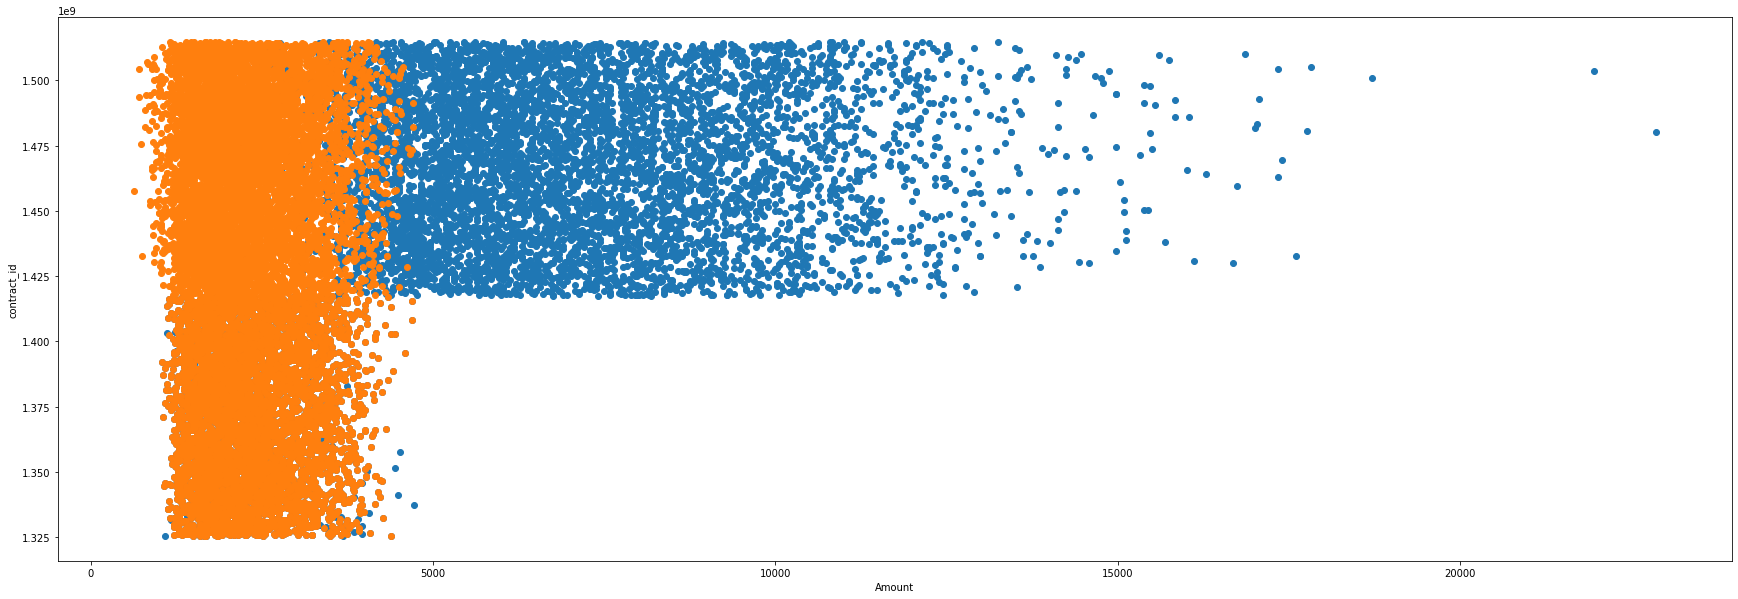

In [941]:
keys = list(first_month_payment.keys())
values = list(first_month_payment.values())
plt.scatter(values, keys)                                                       # Blue : values of payments done 
plt.scatter(values_rent,keys_rent)                                              # orange : values of rent on contract
plt.xlabel('Amount')
plt.ylabel('contract_id')

Deposits made : after Contract Id almost greater than 1425000000 security deposits are taken from the tenants 

In [953]:
# Lets check for contract_id greater than 1425000000
''' for 1504571043 contract agreed_rent=3050'''
first_month_payment[1504571043]     

120598    9150.0
Name: Amount, dtype: float64

In [954]:
'''Thus amount deposited is 3 times of agreed rent '''
9150/3050

3.0

In [851]:
final_df.drop(['contract_start','Payment_date'], axis=1, inplace=True)

In [852]:
grp=final_df.groupby(final_df['full_name'])
grouping_df=grp.first()
print(grouping_df.shape)
grouping_df.head()

(10148, 8)


,postcode,rent,Duration,frequency_of_payment,Amount,payment_method_BANK_TRANSFER,payment_method_CASH,payment_method_DIRECT_DEBIT
full_name,,,,,,,,
A MateoChen1961-05-08,94107.0,3370.0,NaN,36,3384.041667,36,0,0
A ShaadThrelkeld1989-08-24,92808.0,2250.0,NaN,36,2296.875000,0,0,36
A'AniylahBautista1972-12-27,91790.0,1770.0,1003.0,33,1974.656250,34,0,0
A'DoreHager1950-03-27,93940.0,2140.0,NaN,10,2589.400000,0,0,10
A'DoreHager1964-03-18,91355.0,2150.0,NaN,36,2191.805556,0,0,36


In [853]:
'''contracts less than 3 months''' 
df_less_than_3m= grouping_df[grouping_df['frequency_of_payment']<3].shape[0]
print('contracts less than 3 months',df_less_than_3m)                                                                 # Ans: 183

'''contracts less than 6 months''' 
df_less_than_6m= grouping_df[grouping_df['frequency_of_payment']<6].shape[0]
print('contracts less than 6 months',df_less_than_6m)                                                                 # Ans: 832

'''contracts less than 12 months''' 
df_less_than_12m= grouping_df[grouping_df['frequency_of_payment']<12].shape[0]
print('contracts less than 12 months',df_less_than_12m)                                                               # Ans: 2174

'''contracts atleast 18 months''' 
df_atleast_than_18m= grouping_df[grouping_df['frequency_of_payment']>18].shape[0]
print('contracts atleast 18 months',df_atleast_than_18m)                                                              # Ans: 6550

'''contracts atleast 24 months''' 
df_atleast_than_24m= grouping_df[grouping_df['frequency_of_payment']>24].shape[0]                                     # Ans: 5505
print('contracts atleast 24 months',df_atleast_than_24m)       


contracts less than 3 months 183
contracts less than 6 months 832
contracts less than 12 months 2174
contracts atleast 18 months 6550
contracts atleast 24 months 5505


In [854]:
# How many tenants have used only one payment method? How many more than one?
only_payment=0
multiple_payment=0
for i in grouping_df.index:
  bank_transfer,cash,debit=0,0,0
  if grouping_df.loc[i]['payment_method_BANK_TRANSFER']:
    bank_transfer=1
  if grouping_df.loc[i]['payment_method_CASH']:
    cash=1
  if grouping_df.loc[i]['payment_method_DIRECT_DEBIT']:
    debit=1

  if bank_transfer and cash ==1 or cash and debit==1 or debit and bank_transfer==1  :
    multiple_payment+=1
  else:
    only_payment+=1

In [855]:
print(f'Tenants with single payment option: {only_payment} \nTenants with single payment option: {multiple_payment}')


Tenants with single payment option: 9863 
Tenants with single payment option: 285


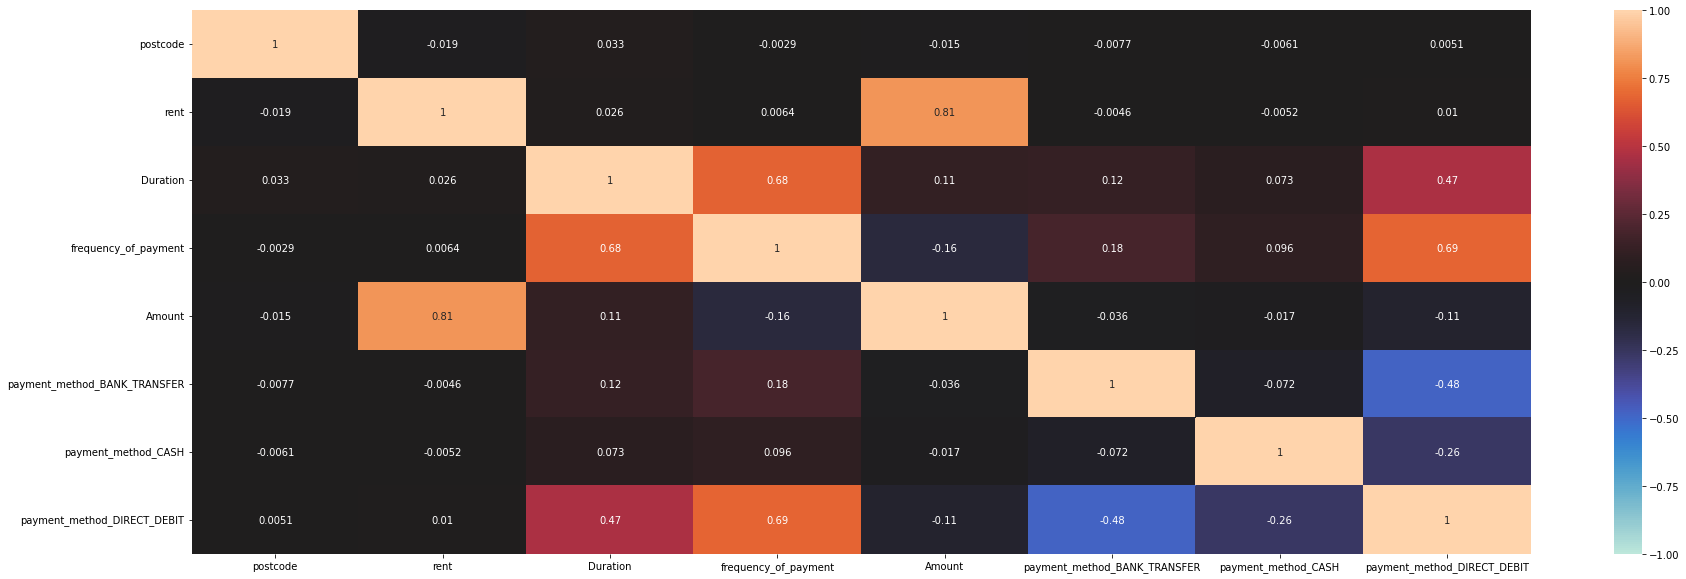

In [856]:
a = final_df.corr()
plt.figure(figsize=(30,10))
sns.heatmap(a,vmin=-1,vmax=1,center=0,annot=True)    

In [857]:
''' 
From the Correlation graph we can see that Duration is highly dependent upon 
the Frequency of payment and mode of payment
'''

final_df.info()                                                                  # We will now create an ML algorithm to predict the Contract Duration as it is important feature for us

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11469 entries, 1504571043 to 1386557095
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   postcode                      11469 non-null  float64
 1   rent                          11469 non-null  float64
 2   full_name                     11469 non-null  object 
 3   Duration                      2306 non-null   float64
 4   frequency_of_payment          11469 non-null  int64  
 5   Amount                        11469 non-null  float64
 6   payment_method_BANK_TRANSFER  11469 non-null  uint8  
 7   payment_method_CASH           11469 non-null  uint8  
 8   payment_method_DIRECT_DEBIT   11469 non-null  uint8  
dtypes: float64(4), int64(1), object(1), uint8(3)
memory usage: 660.8+ KB


In [858]:
''' Creating One hot Encodings for the column Postcode '''

one_hot_entity=['postcode']    
column_one_hot=['postcode']                                               # one hot encoding of Order Status so as to get the gist of number of successful, canceled orders
count=0
for i in column_one_hot:
  temp_df=pd.get_dummies(final_df[i], prefix=one_hot_entity[count])
  count+=1
  final_df=pd.concat([final_df, temp_df], axis=1)

In [859]:
final_df.drop('postcode', axis=1, inplace=True)
final_df.head()

,rent,full_name,Duration,frequency_of_payment,Amount,payment_method_BANK_TRANSFER,payment_method_CASH,payment_method_DIRECT_DEBIT,postcode_90004.0,postcode_90005.0,postcode_90006.0,postcode_90008.0,postcode_90012.0,postcode_90016.0,postcode_90017.0,postcode_90019.0,postcode_90024.0,postcode_90025.0,postcode_90026.0,postcode_90027.0,postcode_90028.0,postcode_90029.0,postcode_90034.0,postcode_90035.0,postcode_90036.0,postcode_90038.0,postcode_90039.0,postcode_90042.0,postcode_90045.0,postcode_90046.0,postcode_90048.0,postcode_90049.0,postcode_90064.0,postcode_90066.0,postcode_90068.0,postcode_90094.0,postcode_90210.0,postcode_90211.0,postcode_90212.0,postcode_90230.0,...,postcode_94804.0,postcode_94806.0,postcode_95008.0,postcode_95014.0,postcode_95032.0,postcode_95035.0,postcode_95050.0,postcode_95051.0,postcode_95062.0,postcode_95110.0,postcode_95112.0,postcode_95117.0,postcode_95123.0,postcode_95124.0,postcode_95125.0,postcode_95126.0,postcode_95128.0,postcode_95129.0,postcode_95131.0,postcode_95136.0,postcode_95207.0,postcode_95219.0,postcode_95608.0,postcode_95630.0,postcode_95670.0,postcode_95678.0,postcode_95687.0,postcode_95747.0,postcode_95758.0,postcode_95814.0,postcode_95816.0,postcode_95823.0,postcode_95825.0,postcode_95826.0,postcode_95831.0,postcode_95834.0,postcode_95835.0,postcode_95926.0,postcode_96001.0,postcode_96003.0
contract_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1504571043,3050.0,ShaanGonzalez1951-07-26,NaN,5,4270.000000,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1379893624,2460.0,BuckleyTurnage1990-01-23,NaN,37,2469.972973,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1442099134,2240.0,MattanelLane1960-04-25,NaN,29,2394.482759,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1404257907,3450.0,JoenWillis1990-02-12,730.0,20,2898.000000,0,1,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1384301607,1710.0,BalkisRichardson1989-07-04,NaN,37,1714.621622,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [865]:
final_df.drop('full_name', axis=1, inplace=True)
final_df.describe()

,rent,Duration,frequency_of_payment,Amount,payment_method_BANK_TRANSFER,payment_method_CASH,payment_method_DIRECT_DEBIT,postcode_90004.0,postcode_90005.0,postcode_90006.0,postcode_90008.0,postcode_90012.0,postcode_90016.0,postcode_90017.0,postcode_90019.0,postcode_90024.0,postcode_90025.0,postcode_90026.0,postcode_90027.0,postcode_90028.0,postcode_90029.0,postcode_90034.0,postcode_90035.0,postcode_90036.0,postcode_90038.0,postcode_90039.0,postcode_90042.0,postcode_90045.0,postcode_90046.0,postcode_90048.0,postcode_90049.0,postcode_90064.0,postcode_90066.0,postcode_90068.0,postcode_90094.0,postcode_90210.0,postcode_90211.0,postcode_90212.0,postcode_90230.0,postcode_90250.0,...,postcode_94804.0,postcode_94806.0,postcode_95008.0,postcode_95014.0,postcode_95032.0,postcode_95035.0,postcode_95050.0,postcode_95051.0,postcode_95062.0,postcode_95110.0,postcode_95112.0,postcode_95117.0,postcode_95123.0,postcode_95124.0,postcode_95125.0,postcode_95126.0,postcode_95128.0,postcode_95129.0,postcode_95131.0,postcode_95136.0,postcode_95207.0,postcode_95219.0,postcode_95608.0,postcode_95630.0,postcode_95670.0,postcode_95678.0,postcode_95687.0,postcode_95747.0,postcode_95758.0,postcode_95814.0,postcode_95816.0,postcode_95823.0,postcode_95825.0,postcode_95826.0,postcode_95831.0,postcode_95834.0,postcode_95835.0,postcode_95926.0,postcode_96001.0,postcode_96003.0
count,11469.000000,2306.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.00000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,...,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000,11469.000000
mean,2354.642951,823.876409,23.672944,2518.293730,3.469265,1.153196,19.067399,0.003749,0.003226,0.002965,0.004011,0.002616,0.002703,0.003052,0.003139,0.002877,0.002354,0.003139,0.001482,0.003139,0.003313,0.002703,0.002965,0.003052,0.002267,0.003400,0.00279,0.002616,0.003575,0.002267,0.003575,0.003924,0.002354,0.003836,0.002877,0.001918,0.003139,0.003226,0.003139,0.003400,...,0.003313,0.003052,0.003052,0.002441,0.003139,0.002441,0.002267,0.002703,0.003400,0.002877,0.002703,0.002267,0.002529,0.003226,0.002005,0.003139,0.002703,0.002703,0.004011,0.003226,0.002616,0.003749,0.003052,0.002093,0.003313,0.002616,0.002877,0.002703,0.003400,0.003836,0.003400,0.003226,0.002267,0.003139,0.003139,0.004185,0.003400,0.002877,0.002616,0.002965
std,770.262553,493.657760,12.161755,1033.729807,9.539586,5.641912,14.406643,0.061119,0.056709,0.054369,0.063207,0.051080,0.051922,0.055160,0.055940,0.053566,0.048465,0.055940,0.038473,0.055940,0.057468,0.051922,0.054369,0.055160,0.047561,0.058217,0.05275,0.051080,0.059686,0.047561,0.059686,0.062519,0.048465,0.061823,0.053566,0.043757,0.055940,0.056709,0.055940,0.058217,...,0.057468,0.055160,0.055160,0.049352,0.055940,0.049352,0.047561,0.051922,0.058217,0.053566,0.051922,0.047561,0.050223,0.056709,0.044739,0.055940,0.051922,0.051922,0.063207,0.056709,0.051080,0.061119,0.055160,0.045699,0.057468,0.051080,0.053566,0.051922,0.058217,0.061823,0.058217,0.056709,0.047561,0.055940,0.055940,0.064560,0.058217,0.053566,0.051080,0.054369
min,630.000000,88.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [866]:
'''
In training set I will take all the rows that have non-null values in duration
column and for testing all the values that are null and then prdeict them
'''
df_train=final_df[final_df['Duration']>=0]
df_test= final_df[final_df['Duration'].isna()]
df_train.shape, df_test.shape

((2306, 343), (9163, 343))

In [867]:
X_train, X_test =df_train.drop('Duration', axis=1),  df_test.drop('Duration', axis=1)
y_train=df_train['Duration']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2306, 342), (9163, 342), (2306,), (1136,))

In [868]:
X_test.shape

(9163, 342)

In [869]:
'''
Using XG Boost Model for prediction of Duration, Lets determine the best set
set of parameters first
''' 

xgb_model = XGBRegressor()

learning_rate= [0.05,0.1, 0.25,0.3]                                                   # various learning rates i will tryout
nax_depth = [2,3,5]      
n_estimators=[20,50,80]                                                                 # various depths that i will try out
parameters = dict(learning_rate=learning_rate, nax_depth=nax_depth, n_estimators=n_estimators,objective=['reg:squarederror'])     
grid = GridSearchCV(xgb_model,parameters,scoring='r2', cv=None)                       

grid_result=grid.fit(X_train.values, y_train)
print ("r2 / variance : ", grid.best_score_,'with parameter: ',grid_result.best_params_)


r2 / variance :  0.5302175452615443 with parameter:  {'learning_rate': 0.25, 'n_estimators': 50, 'nax_depth': 2, 'objective': 'reg:squarederror'}


In [870]:
model = XGBRegressor(max_depth=2,                                                # best set of hyperparameters {'learning_rate': 0.25, 'n_estimators': 50, 'nax_depth': 3, 'objective': 'reg:squarederror'}                  
                     learning_rate=0.25,
                     n_estimators=50,
                     verbosity=0,
                     objective='reg:squarederror')                                                         
model.fit(X_train,y_train)
y_pred_test=model.predict(X_test)
y_pred_train=model.predict(X_train)
print(f'Root Mean error on Training set is {np.sqrt(metrics.mean_squared_error(y_train,y_pred_train))}')                     

Root Mean error on Training set is 320.56774515979475


In [871]:
''' Adding Predictions back of test set back on X_test'''
X_test['Duration']=y_pred_test
''' Joining both Datasets '''
X_train['Duration']=y_train

In [872]:
print(X_test.shape, X_train.shape)
final_df= pd.concat([X_test, X_train])                   # Merging both Datasets
final_df.shape

(9163, 343) (2306, 343)


(11469, 343)

In [873]:
final_df.isna().sum()                                                           # Now we do not have any nulls

rent                            0
frequency_of_payment            0
Amount                          0
payment_method_BANK_TRANSFER    0
payment_method_CASH             0
                               ..
postcode_95835.0                0
postcode_95926.0                0
postcode_96001.0                0
postcode_96003.0                0
Duration                        0
Length: 343, dtype: int64

In [890]:
final_df['frequency_of_payment'].max()

38

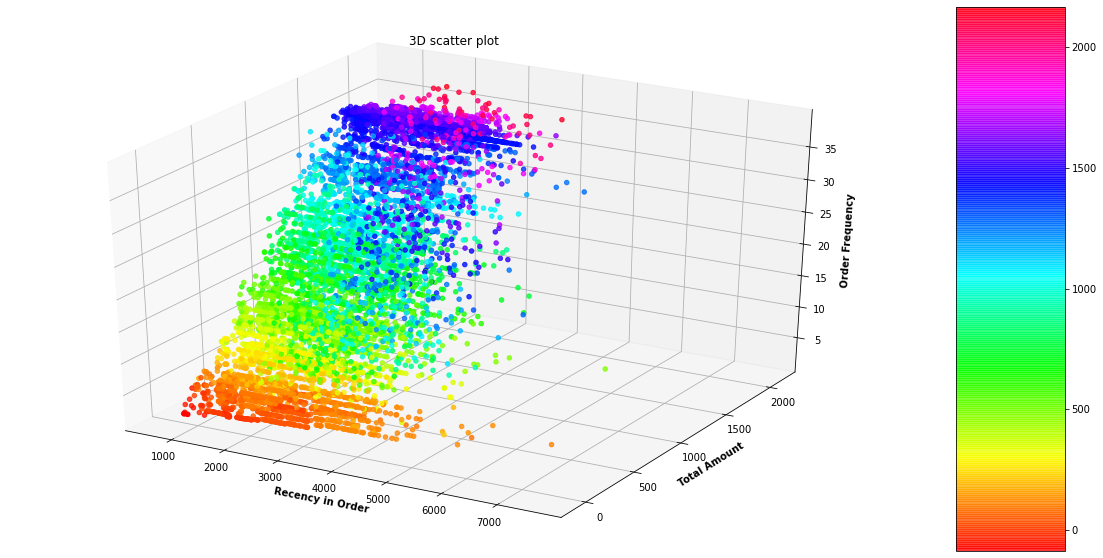

In [874]:
def plot_scatter(final_df):
  fig = plt.figure(figsize = (20, 10))
  ax = plt.axes(projection ="3d")
  # Creating color map
  my_cmap = plt.get_cmap('hsv')
  plot=ax.scatter3D(final_df['rent'],final_df['Duration'],
                    final_df['frequency_of_payment'],
                    cmap = my_cmap,
                    alpha = 0.8,c =(final_df.Duration+final_df.frequency_of_payment) )
  plt.title("3D scatter plot")
  ax.set_zlabel('Order Frequency', fontweight ='bold')
  ax.set_ylabel('Total Amount', fontweight ='bold')
  ax.set_xlabel('Recency in Order', fontweight ='bold')
  fig.colorbar(plot, ax = ax, aspect = 5)
  plt.show()       
                                                                              
plot_scatter(final_df)

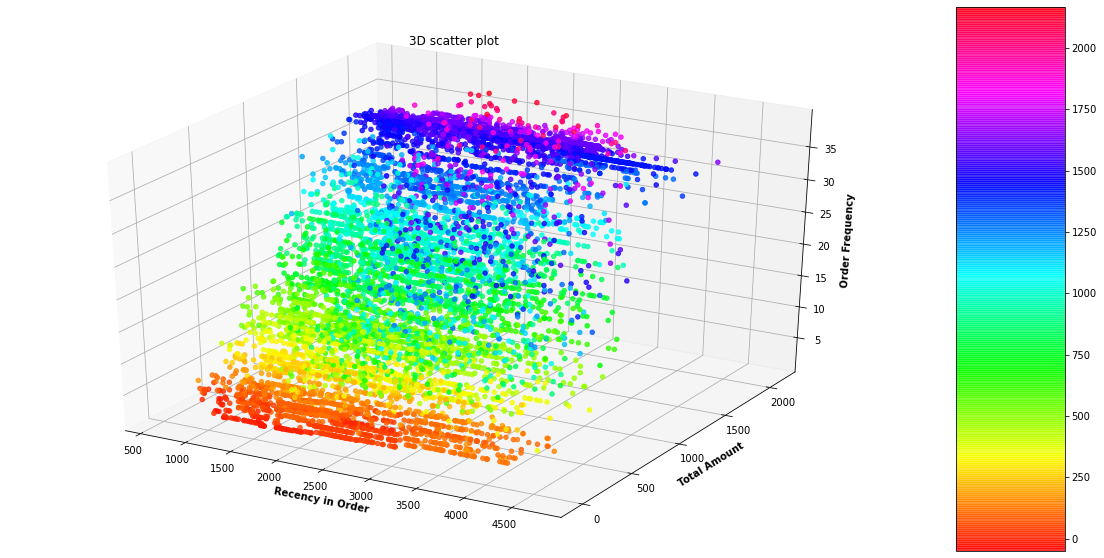

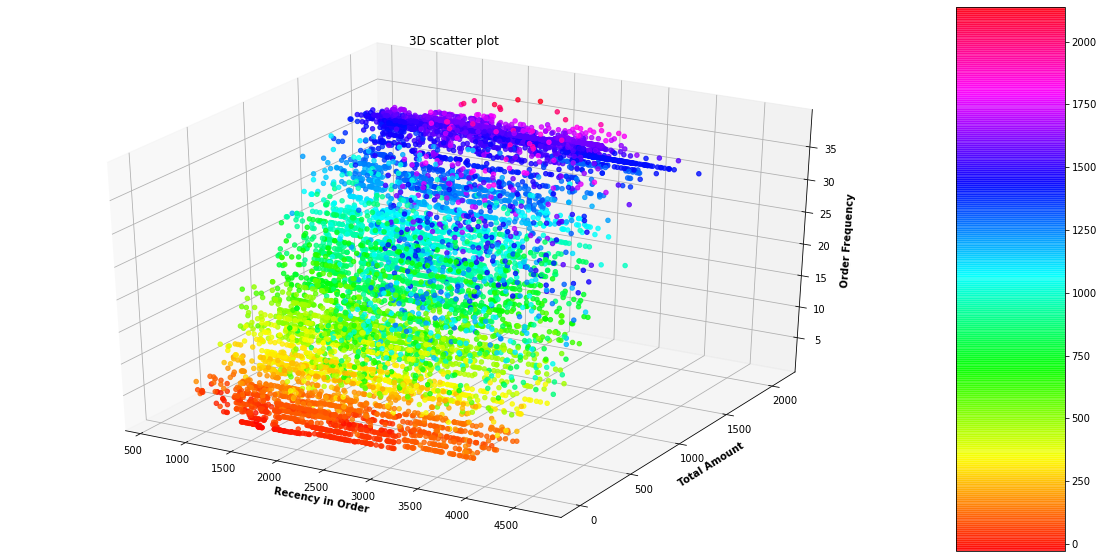

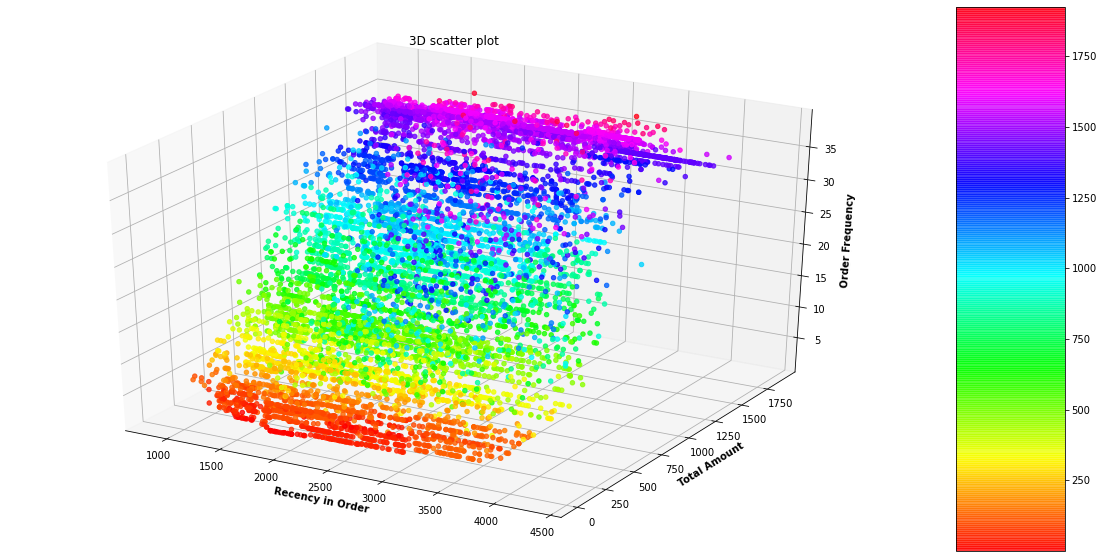

In [876]:
minmax = MinMaxScaler(feature_range=(0, 1))
X = minmax.fit_transform(final_df[['Duration','frequency_of_payment','rent']])

contamination=[0.01,0.025,0.05]
for i in contamination:
  clf = IsolationForest(n_estimators=100, contamination=i, random_state=0)     #Isolation Forest algorithm for anomaly detection
  clf.fit(X)

  temp_df= final_df.copy()
  temp_df['multivariate_anomaly_score'] = clf.decision_function(X)               # predict raw anomaly score
  temp_df['multivariate_outlier'] = clf.predict(X)                               # prediction of a datapoint category outlier or inlier
  temp_df=temp_df[temp_df.multivariate_outlier==1]                             #updating data
                                                            #outliers have been removed
  temp_df.drop(['multivariate_anomaly_score','multivariate_outlier'],axis=1,inplace=True)
  plot_scatter(temp_df)


Looking at the plots we get the Idea of Contamination which is just 1% so we will remove this

(11469, 343)
(11354, 343)


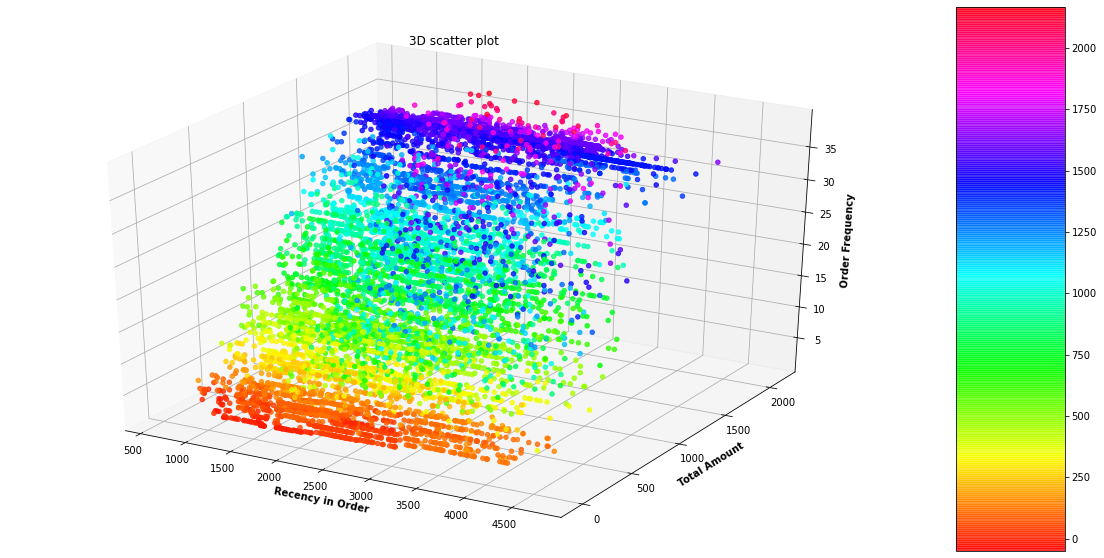

In [877]:
clf = IsolationForest(n_estimators=100, contamination=0.01, random_state=0)     #Isolation Forest algorithm for anomaly detection
clf.fit(X)
print(final_df.shape)
final_df['multivariate_anomaly_score'] = clf.decision_function(X)               # predict raw anomaly score
final_df['multivariate_outlier'] = clf.predict(X)                               # prediction of a datapoint category outlier or inlier
final_df=final_df[final_df.multivariate_outlier==1]                             #updating data
                                                     #outliers have been removed
final_df.drop(['multivariate_anomaly_score','multivariate_outlier'],axis=1,inplace=True)
print(final_df.shape)      
plot_scatter(final_df)


The innertia for : 2 Clusters is: 9875839383.608204
The innertia for : 3 Clusters is: 7311062147.656664
The innertia for : 4 Clusters is: 6080112808.118988


Text(0.5, 1.0, 'Inertia Plot per k')

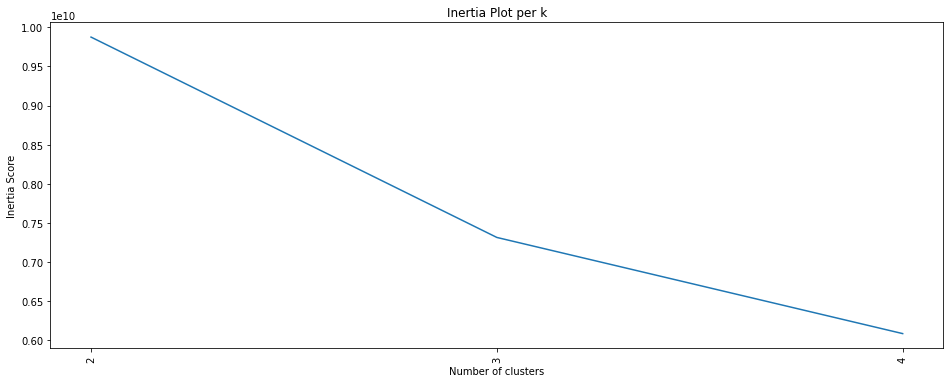

In [878]:
no_of_clusters = range(2,5)
X= final_df[['Duration','frequency_of_payment','rent','Amount','payment_method_BANK_TRANSFER','payment_method_CASH','payment_method_DIRECT_DEBIT']]
'''
As I dont want clustering to happen on basis of Postal code (Location), I will 
remove those coloumns
'''
inertia=[]
for f in no_of_clusters:
    kmeans = KMeans(n_clusters=f, random_state=2)
    kmeans = kmeans.fit(X)
    u = kmeans.inertia_
    inertia.append(u)
    print("The innertia for :", f, "Clusters is:", u)
fig, (ax1) = plt.subplots(1, figsize=(16,6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation='vertical')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia Score')
plt.title("Inertia Plot per k") 

This suggest that ideal number of cluster are 3 but for our use case we will move forward with just 2

In [879]:
kmeans = KMeans(n_clusters=2, random_state=2) 
kmeans = kmeans.fit(X)
kmeans.labels_
predictions = kmeans.predict(X)
unique, counts = np.unique(predictions, return_counts=True)
counts = counts.reshape(1,2)
countscldf = pd.DataFrame(counts, columns = ["Cluster 0","Cluster 1"])
countscldf

,Cluster 0,Cluster 1
0,4111,7243


Explained variance ratio (first two components): [0.77318444 0.16727137 0.05940215]


<Figure size 2160x720 with 0 Axes>

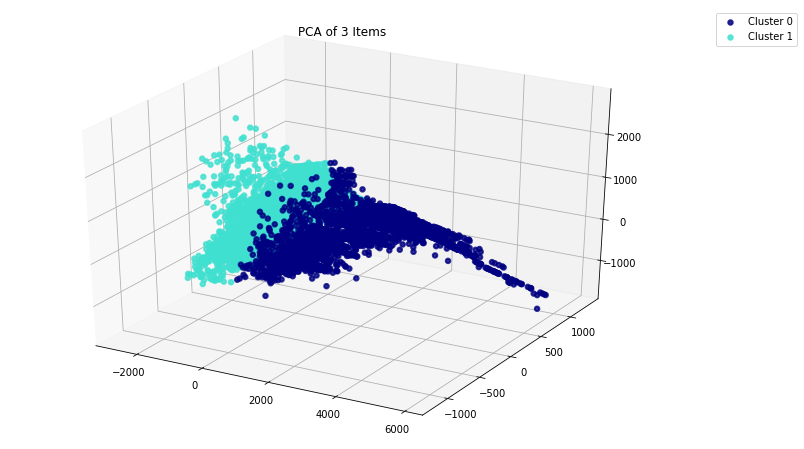

In [880]:
''' 
Using PCA for visualizing these cluster
'''

def pca_val(X,predictions): 
  X = X
  y_num = predictions
  pca = PCA(n_components=3, random_state =1 )
  X_r = pca.fit(X).transform(X)
  return X_r,y_num,pca
def plot_3d(X_r,y_num,pca):
  target_names = ["Cluster 0","Cluster 1"]
  print('Explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))
  plt.figure()
  plt.figure(figsize=(12,8))
  colors = ['navy', 'turquoise', 'darkorange', 'red']
  lw = 2
  ax = plt.axes(projection ="3d")

  for color, i, target_name in zip(colors, [0, 1], target_names):
      ax.scatter3D(X_r[y_num == i, 0], X_r[y_num == i, 1],X_r[y_num == i, 2], color=color, alpha=.8, lw=lw,label=target_name)
      
  plt.legend(loc='best', shadow=False, scatterpoints=1)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
  plt.title('PCA of 3 Items')  
  plt.show()                                                       #these 3 components represents 95% Variance in data
    
X_r,y_num,pca=pca_val(X,predictions)
plot_3d(X_r,y_num,pca)

In [881]:
final_df['Cluster']=predictions

In [882]:
''' Now lets see which cluster point towards good or bad'''
final_df[final_df['Cluster']==0].head()

,rent,frequency_of_payment,Amount,payment_method_BANK_TRANSFER,payment_method_CASH,payment_method_DIRECT_DEBIT,postcode_90004.0,postcode_90005.0,postcode_90006.0,postcode_90008.0,postcode_90012.0,postcode_90016.0,postcode_90017.0,postcode_90019.0,postcode_90024.0,postcode_90025.0,postcode_90026.0,postcode_90027.0,postcode_90028.0,postcode_90029.0,postcode_90034.0,postcode_90035.0,postcode_90036.0,postcode_90038.0,postcode_90039.0,postcode_90042.0,postcode_90045.0,postcode_90046.0,postcode_90048.0,postcode_90049.0,postcode_90064.0,postcode_90066.0,postcode_90068.0,postcode_90094.0,postcode_90210.0,postcode_90211.0,postcode_90212.0,postcode_90230.0,postcode_90250.0,postcode_90254.0,...,postcode_95008.0,postcode_95014.0,postcode_95032.0,postcode_95035.0,postcode_95050.0,postcode_95051.0,postcode_95062.0,postcode_95110.0,postcode_95112.0,postcode_95117.0,postcode_95123.0,postcode_95124.0,postcode_95125.0,postcode_95126.0,postcode_95128.0,postcode_95129.0,postcode_95131.0,postcode_95136.0,postcode_95207.0,postcode_95219.0,postcode_95608.0,postcode_95630.0,postcode_95670.0,postcode_95678.0,postcode_95687.0,postcode_95747.0,postcode_95758.0,postcode_95814.0,postcode_95816.0,postcode_95823.0,postcode_95825.0,postcode_95826.0,postcode_95831.0,postcode_95834.0,postcode_95835.0,postcode_95926.0,postcode_96001.0,postcode_96003.0,Duration,Cluster
contract_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1504571043,3050.0,5,4270.000000,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,64.390259,0
1329529369,3300.0,37,3300.000000,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1565.932129,0
1447290992,2780.0,27,2985.925926,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,999.418701,0
1430097514,2750.0,34,2927.941176,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1458.568359,0
1432599367,3400.0,33,3616.363636,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1236.916626,0


In [883]:
final_df[final_df['Cluster']==1].head()

,rent,frequency_of_payment,Amount,payment_method_BANK_TRANSFER,payment_method_CASH,payment_method_DIRECT_DEBIT,postcode_90004.0,postcode_90005.0,postcode_90006.0,postcode_90008.0,postcode_90012.0,postcode_90016.0,postcode_90017.0,postcode_90019.0,postcode_90024.0,postcode_90025.0,postcode_90026.0,postcode_90027.0,postcode_90028.0,postcode_90029.0,postcode_90034.0,postcode_90035.0,postcode_90036.0,postcode_90038.0,postcode_90039.0,postcode_90042.0,postcode_90045.0,postcode_90046.0,postcode_90048.0,postcode_90049.0,postcode_90064.0,postcode_90066.0,postcode_90068.0,postcode_90094.0,postcode_90210.0,postcode_90211.0,postcode_90212.0,postcode_90230.0,postcode_90250.0,postcode_90254.0,...,postcode_95008.0,postcode_95014.0,postcode_95032.0,postcode_95035.0,postcode_95050.0,postcode_95051.0,postcode_95062.0,postcode_95110.0,postcode_95112.0,postcode_95117.0,postcode_95123.0,postcode_95124.0,postcode_95125.0,postcode_95126.0,postcode_95128.0,postcode_95129.0,postcode_95131.0,postcode_95136.0,postcode_95207.0,postcode_95219.0,postcode_95608.0,postcode_95630.0,postcode_95670.0,postcode_95678.0,postcode_95687.0,postcode_95747.0,postcode_95758.0,postcode_95814.0,postcode_95816.0,postcode_95823.0,postcode_95825.0,postcode_95826.0,postcode_95831.0,postcode_95834.0,postcode_95835.0,postcode_95926.0,postcode_96001.0,postcode_96003.0,Duration,Cluster
contract_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1379893624,2460.0,37,2469.972973,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1473.363159,1
1442099134,2240.0,29,2394.482759,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1265.084961,1
1384301607,1710.0,37,1714.621622,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1544.511108,1
1367629776,1650.0,37,1652.229730,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1598.853516,1
1477881500,2000.0,15,2266.666667,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,553.867371,1


In [884]:
corr_df= final_df[['Duration','frequency_of_payment','rent','Amount','payment_method_BANK_TRANSFER','payment_method_CASH','payment_method_DIRECT_DEBIT','Cluster']]

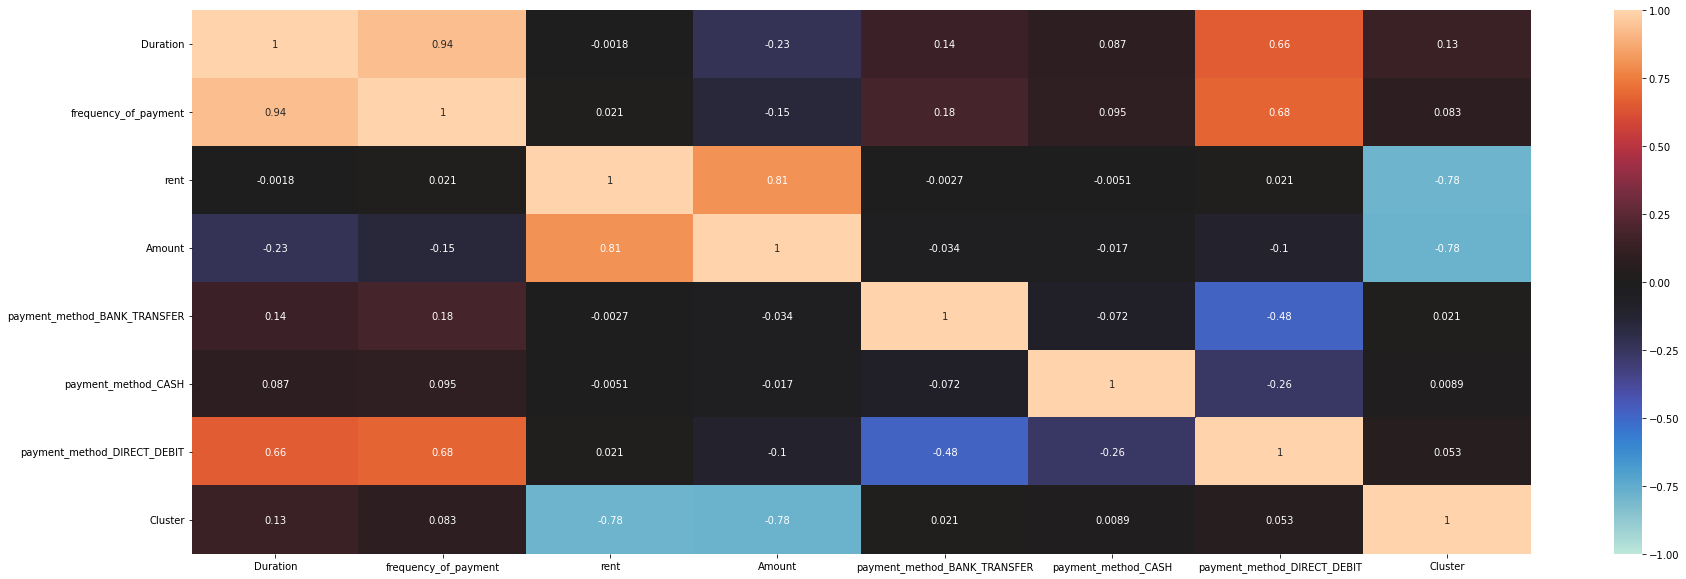

In [885]:
a = corr_df.corr()
plt.figure(figsize=(30,10))
sns.heatmap(a,vmin=-1,vmax=1,center=0,annot=True) 

From the Correlation graph we can state that Actual Rent and Paid Amount is the Most Important Factor to Detemine whether Tenant is Good or Bad ,Cluster 0 represents the Tenants that are bad, wherelse Cluster 1 represents good Tenants

In [894]:
X= final_df.drop(['Cluster','frequency_of_payment','Amount'], axis=1)           # 'frequency_of_payment' and 'Amount' are future characterstis thus can cause data leakage thus removing it
y= final_df['Cluster']

In [895]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
X_train.shape, X_test.shape, X_val.shape

((8174, 341), (1136, 341), (2044, 341))

In [898]:
'''
Using Kfold cross- validation for hyper-parameter Tuning
'''
model=XGBClassifier()                                                           #XGBoost
n_estimators = [30,50,100]
max_depth = [2,4,6]
param_grid = dict(max_depth=max_depth,n_estimators=n_estimators)                                          
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)   
# summarize results
print(Fore.RED+"Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)+Fore.BLUE)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))      

Best: -0.081092 using {'max_depth': 6, 'n_estimators': 100}
-0.188834 (0.006233) with: {'max_depth': 2, 'n_estimators': 30}
-0.158357 (0.006571) with: {'max_depth': 2, 'n_estimators': 50}
-0.136118 (0.008058) with: {'max_depth': 2, 'n_estimators': 100}
-0.141036 (0.005455) with: {'max_depth': 4, 'n_estimators': 30}
-0.113550 (0.004927) with: {'max_depth': 4, 'n_estimators': 50}
-0.093623 (0.004795) with: {'max_depth': 4, 'n_estimators': 100}
-0.119490 (0.007079) with: {'max_depth': 6, 'n_estimators': 30}
-0.095212 (0.007298) with: {'max_depth': 6, 'n_estimators': 50}
-0.081092 (0.006795) with: {'max_depth': 6, 'n_estimators': 100}


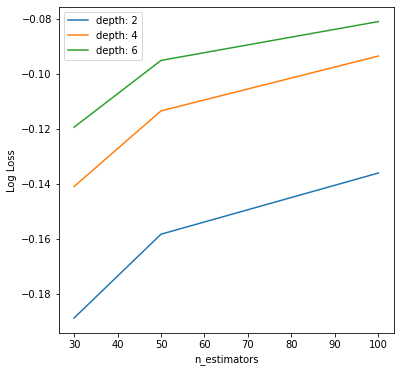

In [899]:
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
plt.figure(figsize=(6,6))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators_vs_max_depth.png')   

In [900]:
model=XGBClassifier(max_depth=6, n_estimators=100, random_state=2)                                 # using {'max_depth': 6, 'n_estimators': 400}
eval_set = [(X_val, y_val)]
model.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose=False)

XGBClassifier(max_depth=6, random_state=2)

Accuracy score on Training Set is 98.50746268656717 and on Test set is 96.74295774647888 

Area under Curve is 0.9680853219840908 



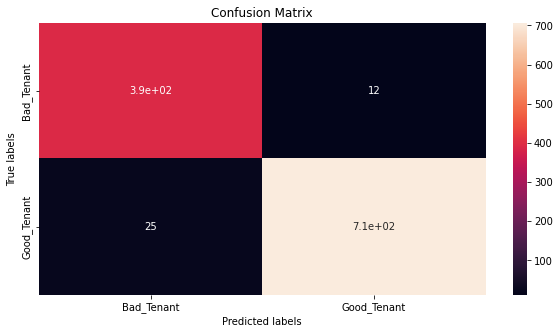



               precision    recall  f1-score   support

  Bad_Tenant       0.94      0.97      0.96       405
 Good_Tenant       0.98      0.97      0.97       731

    accuracy                           0.97      1136
   macro avg       0.96      0.97      0.96      1136
weighted avg       0.97      0.97      0.97      1136



In [901]:
y_pred_test=model.predict(X_test)
y_pred_train=model.predict(X_train)
y_pred_proba =model.predict_proba(X_test)

train_accuracy = accuracy_score(y_pred_train,y_train)
test_accuracy = accuracy_score(y_pred_test,y_test)
area_under_curve= metrics.roc_auc_score(y_test, y_pred_test)

print(Fore.RED+f'Accuracy score on Training Set is {train_accuracy*100} and on Test set is {test_accuracy*100} ')
print(Fore.BLUE+f'\nArea under Curve is {area_under_curve} \n')                      # Thus Model is able to differentiate between both the classes

labels = ['Bad_Tenant', 'Good_Tenant']
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10,5))
ax= plt.subplot()
sns.heatmap(cm_test, annot=True, ax = ax) 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print('\n\n',Fore.GREEN+classification_report(y_test,y_pred_test,target_names=labels))

Answer a few specific questions on the data:

1. How many unique contracts are there in total?

   Ans: 11524

2. How many unique contracts are there with a link to transaction information? 

  Ans: we have transaction information for all the transactions

3. How many unique tenants? 

  Ans: we have 10200 unique Tenants

4. How many tenants with multiple contracts? 

  Ans: 1324 Tenants with multiple contracts 

5. How many contracts such tenants have? 

  Ans: 2 contracts on average thus total =2648

6. How many tenants have a total contract history with less than 3, 6, and 12 months of history,
and with at least 18 and 24 months of history?

  Ans: 
    * contracts less than 3 months 183
    * contracts less than 6 months 832
    * contracts less than 12 months 2174
    * contracts atleast 18 months 6550
    * contracts atleast 24 months 5505

7. How many tenants have used only one payment method? How many more than one?
  * Tenants with single payment option: 9863 
  * Tenants with single payment option: 285

8. What is the relationship between deposit and rent amount agreed in the contract? 

  ans: rent deposited in forst month is exactly 3 times the agreed ren, thus deposite is 2 times of rent/month 

9. Can you find an example of the transactional history for an evicted tenant, for each possible
cause of eviction, and explain the cause of eviction?

  * Yes there are 412 total cases of eviction which happed due to untimely payments

10. How many evictions, per type, are there?

  * ans : 412

In addition, please state clearly the counts that characterize the dataset for modelling:


• How many features are you using? 
  * Ans:6


• How many months of history are you including for transactional features? 
  * Ans: 38


• How many months of history are you using for the labelling window?
  * Ans- 38


• How many examples of each class do you have in the total dataset for modelling? 
  * Ans- bad-4111	, good-7243

• How many examples have you defined for training and testing your models?
  * Ans- training : 8174, testing: 1136